# Реализация Deep Q-Network (DQN)

В этом домашнем задании вам предстоит реализовать DQN — алгоритм аппроксимационного Q-обучения с использованием буфера воспроизведения опыта (experience replay) и целевых сетей (target networks) — и проверить, насколько лучше он будет работать.

**Статьи для ознакомления:**

[1] Оригинальная статья, 2013: https://arxiv.org/pdf/1312.5602.pdf

[2] Расширенная версия, Nature, 2015: https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf

[3] Rainbow, 2017: https://arxiv.org/pdf/1710.0228.pdf


Референс задания взят из https://github.com/yandexdataschool/Practical_RL/tree/master/week04_approx_rl но адаптирован и доработан.

### Руководство по выполнению домашнего задания

Это домашнее задание состоит из двух частей на выбор, которые помогут вам освоить обучение с подкреплением. Сдать нужно одну из них. Первая "отладочная" часть может помочь быстрее отладить код для основного ноутбука, так как задания и код сильно пересекаются, но обучение в отладочной среде занимает гораздо меньше времени.

1. **Отладочный ноутбук (среда CartPole)**

* Что это: Это первая и более простая часть задания. В ней используется среда CartPole, где агент учится балансировать шест.
* Зачем начинать с него: Обучение здесь занимает всего несколько минут, что делает его идеальным для отладки вашего кода. Вы сможете быстро убедиться, что ваш алгоритм работает правильно, прежде чем переходить к более сложным задачам.
* Оценка: За выполнение основных заданий в этом ноутбуке вы можете получить 16 баллов. С помощью бонусных заданий вы сможете добрать оставшиеся баллы (до 12 бонусных баллов).

2. **Основной ноутбук (среда Atari)**

* Что это: Это вторая, более сложная часть. Здесь вы будете работать со средой Atari, что требует от агента решения более комплексных задач.
* Особенности: Обучение в этой среде занимает гораздо больше времени (около 2 часов), поэтому важно, чтобы ваш код был хорошо отлажен.
* Оценка:
    * Основные задания: За их успешное выполнение вы можете получить 20 баллов.
    * Бонусные задания: Если вы выполните эти задания, вы можете получить до 15 баллов, которые будут добавлены к вашей итоговой оценке за весь курс.


**Рекомендуемый порядок выполнения:**
Начните с ноутбука CartPole, чтобы отладить алгоритм, а затем перенесите его в ноутбук Atari для получения максимального результата и дополнительных баллов.

**Система получения баллов для наглядности преставлена табличкой (зелёным отмечены бонусы)**

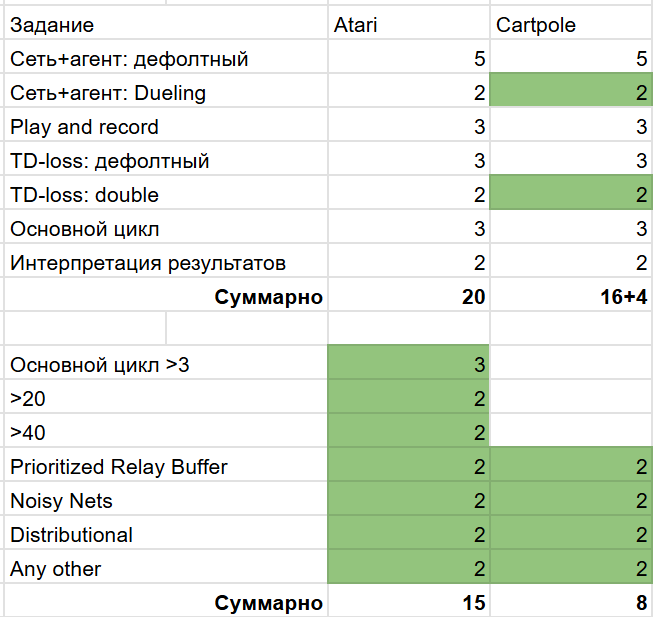

### Инструкции по использованию ресурсов Colab:

* После решения всех заданий **подключитесь к среде с GPU**: "Среда выполнения" ->  "Сменить среду выполнения" -> "Графический процессор T4". В среднем GPU **хватит на пару часов** (зависит от того, насколько часто вы пользуетесь колабом и от загруженности ресурсов гугла) -- должно хватить на обучение отлаженной модели до нужных баллов.
* **Не тратьте ресурсы GPU на дебаг**, они могут быстро закончиться, включайте среды с GPU только для обучения готовых моделей
* Можно сделать **несколько гугл-аккаунтов** и обучать на других аккаунтах, когда закончатся ресурсы GPU, либо попробовать через сутки на этом же аккаунте обучить снова.
* Можно подключить диск, чтобы **сохранять веса и логи обученной модели**, чтобы не терять прогресс обния, когда коллаб перезапустится. Ниже мы реализовали такую возможность для вас.
* Вкладки в Colab могут отключаться от бездействия. Чтобы так не было, **сделайте так, чтобы ваш ноутбук не отключался от бездействия** (Скачайте Amphetamin на macbook/ найдите "питание и  спящий режим" в настройках на windows и увеличить время перехода в спящий режим)

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    os.makedirs('dqn', exist_ok=True)
    os.makedirs('test_td_loss', exist_ok=True)

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/atari_wrappers.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/utils.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/replay_buffer.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/framebuffer.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/analysis.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/dqn/logger.py -P dqn/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/test_td_loss/compute_td_loss.py -P test_td_loss/
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/requirements.txt

    !pip install -r requirements.txt

    !touch .setup_complete

# Этот код создает виртуальный дисплей для отрисовки игровых изображений.
# Он не будет иметь эффекта, если ваша машина уже оснащена монитором.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [78]:
%matplotlib inline
import gymnasium as gym
from gymnasium.wrappers import FrameStackObservation
import ale_py
import numpy as np
import matplotlib.pyplot as plt
from atari_wrappers import EpisodicLifeEnv, FireResetEnv, Wrapper
gym.register_envs(ale_py)
from utils import linear_decay, is_enough_ram
from logger import Logger

### Давайте поиграем в старые видеоигры
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/nerd.png)

На этот раз мы применим аппроксимационное Q-обучение к игре Atari под названием Breakout. Это не самая сложная игра, но она определенно сложнее всего, что мы пробовали раньше.

**Это различные версии Breakout, предоставляемые Gymnasium:**

In [3]:
all_names = list(gym.envs.registry.keys())
names_breakout = [name for name in all_names if "Break" in name]
names_breakout

['Breakout-v0',
 'Breakout-v4',
 'BreakoutNoFrameskip-v0',
 'BreakoutNoFrameskip-v4',
 'ALE/Breakout-v5']

In [4]:
ENV_NAME = "ALE/Breakout-v5"

Если вам интересно узнать больше о средах Atari в Gymnasium, пожалуйста, обратитесь к:
- [4] Документация Gymnasium: https://gymnasium.farama.org/environments/atari/
- [5] Более длинная статья: https://arxiv.org/abs/1709.06009
- [6] Более короткая статья: https://www.ijcai.org/Proceedings/2018/0787.pdf

На данный момент достаточно знать о средах v5 следующее:
- Среды v5 рекомендуются к использованию.
- `frame_skip=5`: агенту показывается каждый 5-й кадр, а выбранное действие выполняется в течение следующих 5 шагов.
- Случайность вносится параметром `repeat_action_probability=0.25`: с этой вероятностью вместо выбранного действия выполняется предыдущее.

## Знакомство со средой

**Давайте посмотрим, как выглядят наблюдения (observations).**

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


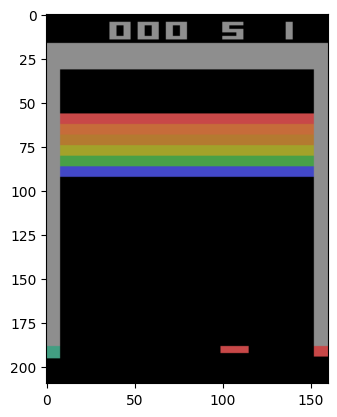

In [5]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()

**Еще несколько наблюдений, полученных в результате случайных действий**

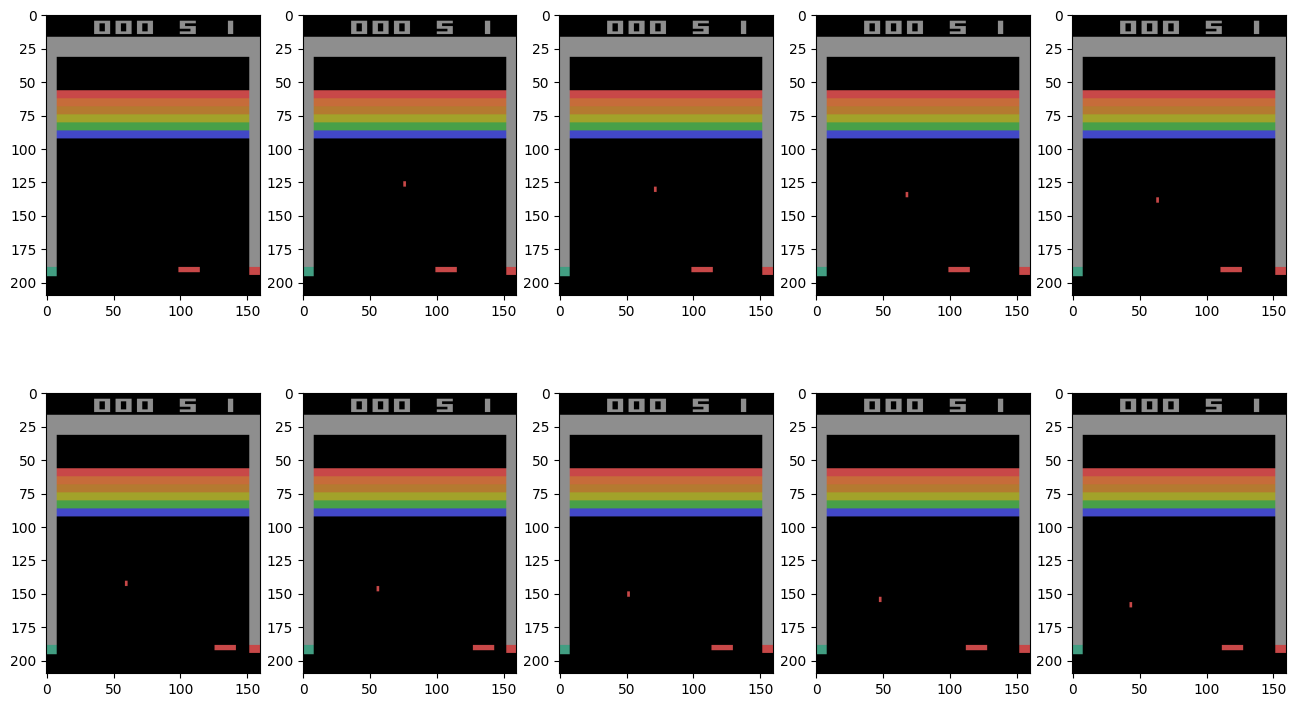

In [6]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

**Об игре:** У вас 5 жизней, и вы получаете очки за разрушение стены. Верхние кирпичи приносят больше очков, чем нижние. Доступно 4 действия: начать игру (нужно вызывать в начале и после каждой потери жизни), двигаться влево, двигаться вправо и ничего не делать.

Существуют некоторые общие обертки, используемые для сред Atari.

**Давайте посмотрим на значения действий:**

In [7]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

1. `NOOP` означает действие "ничего не делать".
2. `RIGHT` и `LEFT` перемещают платформу в соответствующем направлении.
3. `FIRE` выпускает мяч в начале каждой жизни.

В этом задании мы обернем среду так, чтобы действие `FIRE` выполнялось автоматически в начале жизни. Это превратит действие `FIRE` в еще один `NOOP`.
Также мы обернем среду так, чтобы эпизод длился одну жизнь вместо пяти.
Эти преобразования не рекомендуются в статье [5], но они были сделаны в оригинальной статье [1] и помогут обучению сойтись быстрее.

**Давайте немного поиграем.**

Обратите внимание на аргументы `zoom` и `fps` в функции `play`. Управление: A, D, пробел.

In [8]:
# # Не работает в Colab.
# Даже на локальном ноутбуке ломает рендеринг matplotlib. Поэтому рекомендуется перезапускать ноутбук после игры.
# # Используйте клавишу Escape, чтобы продолжить.

# from gymnasium.utils.play import playa

# play(env=gym.make(ENV_NAME, render_mode="rgb_array"), zoom=4, fps=10)

## Обертки для среды (Wrapping)

In [9]:
def make_basic_env():
    return gym.make(ENV_NAME, render_mode="rgb_array")

### Обработка игрового изображения

Давайте проверим форму и тип данных наблюдения:

In [10]:
env = make_basic_env()
obs, *_ = env.reset()
obs.shape, obs.dtype

((210, 160, 3), dtype('uint8'))

Исходные изображения Atari большие, по умолчанию 210x160x3. Однако для обучения нам не нужен такой уровень детализации.

Мы можем сэкономить много времени, предварительно обработав игровое изображение, включая:
* Изменение размера до меньшей формы, 64x64 (или 84x84, что используется в литературе).
* Преобразование в оттенки серого.
* Обрезку нерелевантных частей изображения (верх, низ и края) [мы этого делать не будем].

Изображения имеют тип `uint8`.
`uint8` означает 8-битное беззнаковое целое число.
Мы будем хранить 10^5 или 10^6 наблюдений в памяти (ОЗУ), поэтому обратим внимание на сохранение 8-битного типа после наших преобразований.

(84, 84) uint8


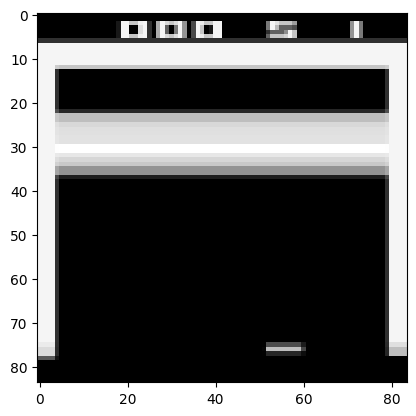

In [11]:
def apply_gray_scale_wrap(env):
    # С выбранными ниже значениями аргументов обертка gym.wrappers.AtariPreprocessing
    # только преобразует изображения в оттенки серого и уменьшает их до screen_size
    env = gym.wrappers.AtariPreprocessing(
        env,
        noop_max=0,  # значение по умолчанию 30 может быть вредным с FireResetEnv и frame_skip=5
        frame_skip=1,  # frame_skip уже установлен на 5 внутри среды
        terminal_on_life_loss=False,  # мы делаем это явно в обертке FireResetEnv
        screen_size=84  # пожалуйста, используйте 84 (стандартное значение) или 64 (сэкономит вычисления и память)
    )
    return env


env = make_basic_env()
env = apply_gray_scale_wrap(env)

obs, *_ = env.reset()

assert obs.dtype == np.dtype('uint8')

print(obs.shape, obs.dtype)
plt.imshow(obs, cmap='gray')
plt.show()

### Специфичные для Atari обертки

Мы пытаемся немного упростить себе жизнь с помощью следующих оберток:
1. `EpisodicLifeEnv`: делает сигнал о том, что потеря мяча — это плохо, более явным.
2. `FireResetEnv`: с ней агенту не нужно выполнять специальное действие, чтобы выпустить мяч в начале жизни.

(84, 84) uint8


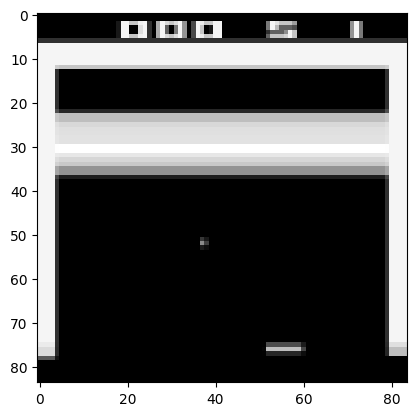

In [12]:
def apply_atary_specific_wrap(env):
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    return env


env = make_basic_env()
env = apply_gray_scale_wrap(env)
env = apply_atary_specific_wrap(env)

obs, *_ = env.reset()

print(obs.shape, obs.dtype)
plt.imshow(obs, cmap='gray')
plt.show()

### FrameStack (Стэк кадров)
Чтобы сделать игру играбельной из одного наблюдения (обратите внимание на направление мяча), мы объединяем (стэкаем) 4 последовательных кадра:

Обновился класс FrameStack на FrameStackObservation

Release Notes

v1.0.0 release notes
- AutoResetWrapper -> Autoreset
- FrameStack -> FrameStackObservation
- PixelObservationWrapper -> AddRenderObservation1

Форма: (4, 84, 84), тип данных: uint8, тип объекта Python: <class 'numpy.ndarray'>

Кадры, слева направо: от старых к новым. Мяч падает.


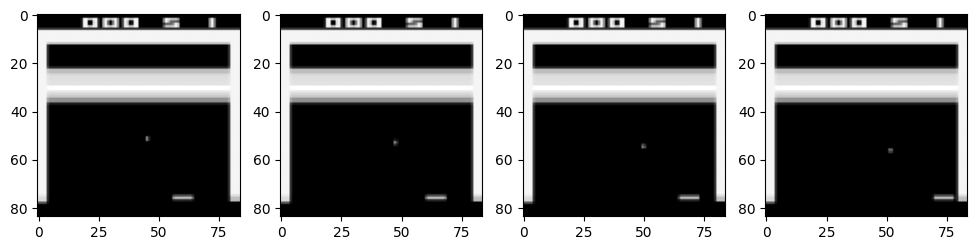

In [13]:
N_FRAMES_STACKED = 4


def make_final_env(apply_frame_stack=True):
    """
    Создает среду со всеми примененными обертками.
    Среда предназначена для непосредственного использования в качестве входа для алгоритма RL.

    apply_frame_stack=False может быть полезно для векторизованных сред, которые не требуются для этого задания.
    """
    env = make_basic_env()
    env = apply_gray_scale_wrap(env)
    env = apply_atary_specific_wrap(env)
    if apply_frame_stack:
        # ВАШ КОД
        env = FrameStackObservation(env, stack_size=N_FRAMES_STACKED)
# ВАШ КОД ЗАКОНЧИЛСЯ
    return env


env = make_final_env()

obs, *_ = env.reset()
print(f"Форма: {obs.shape}, тип данных: {obs.dtype}, тип объекта Python: {type(obs)}")
for _ in range(N_FRAMES_STACKED - 1):
    obs, *_ = env.step(env.action_space.sample())
print()


print("Кадры, слева направо: от старых к новым. Мяч падает.")
_, axes = plt.subplots(figsize=(len(obs) * 3, 4), ncols=len(obs))
for ax, frame in zip(axes, obs):
    ax.imshow(frame, cmap='gray')
plt.show()

**Это окончательная версия среды, на которой мы будем обучать RL-агента.**

**Давайте обсудим представление наблюдения.**
Наблюдение — это стэк из 4 кадров в оттенках серого с уменьшенным разрешением.
Память (ОЗУ, RAM) — это очень востребованный ресурс в этой задаче. Поэтому:
1. Мы используем тип данных `uint8` вместо `float32`, на котором будет работать нейронная сеть.
2. Мы не представляем их как `numpy.ndarray`. Вместо этого `gym.wrappers.FrameStack` использует **LazyFrames**. Два последовательных наблюдения делят 3 из 4 кадров. `LazyFrames` используют этот факт для экономии памяти.
Когда мы подаем наблюдения в нейронные сети, мы должны помнить о масштабировании их в диапазон `[0, 1]`. Мы реализуем масштабирование как первый слой нейронной сети, но об этом позже.

**Мяч падает, но это трудно заметить. Давайте определим функцию для рендеринга более понятных для человека изображений:**

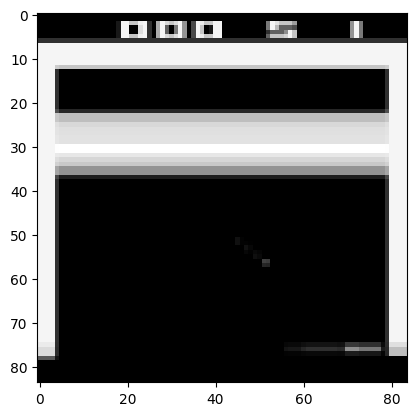

In [14]:
def merge_frame_stack_to_plot(frame_stack_obs: np.ndarray):
    """
    Вспомогательная функция для отображения стэка кадров как одного понятного для человека изображения.

    Более яркие пиксели — более новые, бледные — более старые.
    Движение происходит от бледного к яркому.

    Примечание! Эта функция предназначена для удобства человеческого зрения и НЕ должна использоваться как часть
    предобработки данных для агента Reinforcement Learning.
    """
    weights = np.ones(frame_stack_obs.shape[0], dtype=float)
    weights[-1] += weights.sum()
    weights /= weights.sum()
    result = (weights[:, None, None] * np.array(frame_stack_obs)).sum(0)
    return result


obs_joint = merge_frame_stack_to_plot(obs)
plt.imshow(obs_joint,  cmap='grey')
plt.show()

Надеюсь, так лучше.

In [15]:
N_ACTIONS = env.action_space.n
STATE_SHAPE = env.observation_space.shape

**Давайте посмотрим, можно ли еще играть в игру после применения оберток.**
Во время игры кажется, что обертка `EpisodicLifeEnv` не работает, но на самом деле это не так (потому что после потери жизни новый мяч запускается автоматически — это означает, что обертка `FireResetEnv` понимает, что начался новый эпизод).

**На данный момент не поддерживается.**

## DQN как он есть (15 баллов)

### Построение сети и агента (7 баллов)

Теперь нам нужно построить нейронную сеть, которая может отображать изображения в Q-значения состояний. Эта сеть будет вызываться на каждом шаге агента, так что лучше, чтобы это была не ResNet-152, если у вас нет нескольких GPU. Вместо этого можно использовать свертки с шагом (strided convolutions) и небольшим количеством признаков, чтобы сэкономить время и память.

Вы можете создать любую архитектуру, но ниже на диаграммах вы найдете пару примеров.

**Дуэльная сеть (Dueling Network):**
Статья: https://arxiv.org/pdf/1511.06581.pdf
$$Q_{\theta}(s, a) = V_{\eta}(f_{\xi}(s)) + A_{\psi}(f_{\xi}(s), a) - \frac{\sum_{a'}A_{\psi}(f_{\xi}(s), a')}{N_{actions}},$$
где $\xi$, $\eta$ и $\psi$ — это, соответственно, параметры
общего энкодера $f_\xi$, потока ценности $V_\eta$ и потока преимущества $A_\psi$; а $\theta = \{\xi, \eta, \psi\}$ — их объединение.

Вот как это выглядит:

Простая версия, ожидает height=width=64

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/week04_approx_rl/img/dueling_basic.png)

Nature DQN ([2]), ожидает height=width=84

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/week04_approx_rl/img/dueling_nature.png)


In [16]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Эти константы будут полезны

In [17]:
N_ACTIONS, N_FRAMES_STACKED

(np.int64(4), 4)

In [18]:
class ConvBackbone(nn.Sequential):
    """
    Сверточная часть модели DQN.
    Пожалуйста, не думайте здесь о масштабировании входа: это будет реализовано ниже.
    """

    def __init__(self, c_in: int = N_FRAMES_STACKED) -> None:
        # ВАШ КОД
        super().__init__(
            nn.Conv2d(c_in, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )
# ВАШ КОД ЗАКОНЧИЛСЯ


class DuelingDqnHead(nn.Module):
    """
    Реализует логику Dueling DQN.
    Пожалуйста, не думайте здесь о масштабировании градиента: это будет реализовано ниже.
    """

    def __init__(self, n_actions, inp_size=64 * 7 * 7, hidden_size=512) -> None:
        super().__init__()
# ВАШ КОД
        self.adv_stream = nn.Sequential(
            nn.Linear(inp_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )
        self.value_stream = nn.Sequential(
            nn.Linear(inp_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
# ВАШ КОД ЗАКОНЧИЛСЯ

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 2, x.shape  # (batch_size, n_features)
        # при подсчёте среднего помните о том, что x - это батч данных
# ВАШ КОД
        advantages = self.adv_stream(x)
        value = self.value_stream(x)

        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values
# ВАШ КОД ЗАКОНЧИЛСЯ

Проведем простой тест для архитектуры сети:

In [19]:
@torch.no_grad()
def test_network_part_shapes(backbone, head):
    batch_size = 3
    env = make_final_env()
    s, _ = env.reset()
    inp = torch.rand(batch_size, *s.shape, dtype=torch.float32)

    features = backbone(inp)
    qvalues = head(features)

    assert features.ndim == 2, features.shape
    assert features.shape[0] == batch_size, features.shape

    assert qvalues.ndim == 2, qvalues.shape
    assert qvalues.shape[0] == batch_size, qvalues.shape
    assert qvalues.shape[1] == N_ACTIONS, qvalues.shape

    print("Тест пройден!")


test_network_part_shapes(
    backbone=ConvBackbone(N_FRAMES_STACKED),
    head=DuelingDqnHead(N_ACTIONS, inp_size=3136),
)

Тест пройден!


**Теперь соберем полную модель.**

In [20]:
MAX_UINT_8 = 2 ** 8 - 1


class InputScaler(nn.Module):
    def __init__(self, mult=1 / MAX_UINT_8):
        super().__init__()
        self.mult = mult

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x.float() * self.mult


class GradScalerFunctional(torch.autograd.Function):
    """
    torch.autograd.Function работает как Identity на прямом проходе
    и масштабирует градиент на scale_factor на обратном проходе.
    """
    @staticmethod
    def forward(ctx, input, scale_factor):
        ctx.scale_factor = scale_factor
        return input

    @staticmethod
    def backward(ctx, grad_output):
        scale_factor = ctx.scale_factor
        grad_input = grad_output * scale_factor
        return grad_input, None


class GradScaler(nn.Module):
    """
    nn.Module, инкапсулирующий GradScalerFunctional
    """

    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return GradScalerFunctional.apply(x, self.scale_factor)


class DQNetworkDueling(nn.Sequential):
    def __init__(self, c_in: int, n_actions: int) -> None:
        input_scaler = InputScaler()  # входы поступают из диапазона uint8
        backbone = ConvBackbone(c_in=c_in)
        grad_scaler = GradScaler(1 / 2**0.5)  # Dueling DQN предлагает масштабировать градиент на 1 / sqrt(2)
        head = DuelingDqnHead(n_actions=n_actions, inp_size=3136)
        super().__init__(input_scaler, backbone, grad_scaler, head)

In [21]:
@torch.no_grad()
def test_network_shapes(model):
    batch_size = 3
    env = make_final_env()
    s, _ = env.reset()
    inp = torch.tensor(np.array(s)[None], dtype=torch.uint8).expand(batch_size, -1, -1, -1)

    qvalues = model(inp)

    assert qvalues.ndim == 2, qvalues.shape
    assert qvalues.shape[0] == batch_size, qvalues.shape
    assert qvalues.shape[1] == N_ACTIONS, qvalues.shape

    print("Тест пройден!")


test_network_shapes(model=DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS))

Тест пройден!


**Теперь обернем нашу модель в класс `Agent`.**
Он будет реализовывать эпсилон-жадную политику на массивах numpy.

In [38]:
class DQNAgent(nn.Module):
    """
    Эпсилон-жадная политика с оценщиком Q-значений на основе torch.nn.Module.
    """

    def __init__(self, q_network: nn.Module, epsilon=1) -> None:
        super().__init__()
        self.epsilon = epsilon
        self.q_network = q_network

    def forward(self, state_t):
        """
        принимает наблюдение агента (тензор), возвращает q-значения (тензор)
        :param state_t: батч из 4-кадровых буферов, форма = [batch_size, 4, h, w]
        """
# ВАШ КОД
        qvalues = self.q_network(state_t)
# ВАШ КОД ЗАКОНЧИЛСЯ
        return qvalues

    @torch.no_grad()  # здесь нам не нужен автоград, так что сэкономим вычисления
    def get_qvalues(self, states: np.ndarray) -> np.ndarray:
        """
        похоже на forward, но работает с массивами numpy, а не с тензорами
        """
        model_device = next(self.parameters()).device
        states_pt = torch.tensor(
            np.array(states), device=model_device, dtype=torch.uint8
        )
# ВАШ КОД
        qvalues_pt = self.forward(states_pt)
# ВАШ КОД ЗАКОНЧИЛСЯ
        qvalues = qvalues_pt.data.cpu().numpy()
        return qvalues

    def sample_actions_by_qvalues(self, qvalues: np.ndarray, greedy: bool = False) -> np.ndarray:
        """выбирает действия на основе q-значений. Использует эпсилон-жадную стратегию исследования."""
# ВАШ КОД
        batch_size, n_actions = qvalues.shape

        if greedy:
            # Жадное действие - выбираем действие с максимальным Q-значением
            actions = np.argmax(qvalues, axis=1)
        else:
            # Эпсилон-жадная стратегия
            actions = np.argmax(qvalues, axis=1)

            # Случайные действия для исследования
            random_mask = np.random.random(batch_size) < self.epsilon
            random_actions = np.random.randint(n_actions, size=batch_size)
            actions[random_mask] = random_actions[random_mask]

        epsilon_greedy_actions = actions
        return epsilon_greedy_actions
# ВАШ КОД ЗАКОНЧИЛСЯ

    def sample_actions(self, states: np.ndarray, greedy: bool = False) -> np.ndarray:
        qvalues = self.get_qvalues(states)
        actions = self.sample_actions_by_qvalues(qvalues, greedy=greedy)
        return actions

In [39]:
test_network_shapes(
    model=DQNAgent(DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS))
)

Тест пройден!


In [40]:
agent = DQNAgent(
    DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS),
    epsilon=0.5
).to(device)

Теперь давайте проверим нашего агента, чтобы убедиться, что он не вызывает ошибок.

In [41]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000, seed=None):
    """ Играет n_games полных игр. Если greedy=True, выбирает действия как argmax(q-значений). Возвращает среднюю награду. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset(seed=seed)
        reward = 0
        for _ in range(t_max):
            action = agent.sample_actions(np.array(s)[None], greedy=greedy)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)


print(evaluate(env, agent, n_games=1, greedy=False))
print(evaluate(env, agent, n_games=1, greedy=True))

1.0
0.0


### Буфер воспроизведения опыта (Experience Replay)
Для этого задания мы предоставляем вам готовый буфер воспроизведения опыта.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)


Интерфейс довольно прост:
* `exp_replay.add(obs, act, rw, next_obs, done)` - сохраняет кортеж (s, a, r, s', done) в буфер
* `exp_replay.sample(batch_size)` - возвращает наблюдения, действия, награды, следующие наблюдения и флаги завершения для `batch_size` случайных сэмплов.
* `len(exp_replay)` - возвращает количество элементов, хранящихся в буфере.

In [54]:
import random


class ReplayBuffer(object):
    def __init__(self, size):
        """Создаёт буфер воспроизведения.
        Параметры
        ----------
        size: int
            Максимальное количество переходов, которые можно хранить в буфере.
            При переполнении буфера старые записи удаляются.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.asarray(obs_t))
            actions.append(np.asarray(action))
            rewards.append(reward)
            obses_tp1.append(np.asarray(obs_tp1))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones),
        )

    def sample(self, batch_size):
        """Выбирает случайную партию переходов из буфера.
        Параметры
        ----------
        batch_size: int
            Сколько переходов нужно выбрать.
        Возвращает
        -------
        obs_batch: np.array
            партия наблюдений
        act_batch: np.array
            партия действий, выполненных в состоянии obs_batch
        rew_batch: np.array
            вознаграждения, полученные в результате выполнения act_batch
        next_obs_batch: np.array
            следующие наблюдения после выполнения act_batch
        done_mask: np.array
            done_mask[i] = 1, если выполнение act_batch[i] привело к завершению эпизода,
            и 0 в противном случае.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

In [55]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(), 1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "Размер буфера должен быть 10, так как это его максимальная вместимость"

### Play and record (3 балла)

**Функция `play_and_record`, определенная ниже, является основным способом взаимодействия агента со средой во время обучения.**

Ранее мы обучали RL-алгоритмы на целых эпизодах.
На этот раз мы будем поддерживать среду в постоянном рабочем состоянии и получать небольшие порции взаимодействий с ней.

Агент выполняет несколько действий (4 действия в [2] и [3]), соответствующие кортежи (s, a, r, s', terminated) помещаются в буфер воспроизведения.
Каждый раз, когда эпизод заканчивается (т.е. `truncated` или `terminated`), среда сбрасывается, и процедура продолжается как обычно.

Чтобы сделать первый шаг в постоянно работающей среде, агенту необходимо знать ее состояние. В этом и заключается смысл аргумента `initial_state` функции.

Стоит отметить, что агент не обучается на свежих кортежах немедленно. Агент обучается на выборках, которые извлекаются из буфера.

**Примечание по реализации:**
Мы определяем протокол `ActionSampler`. Его цель — позволить функции `play_and_record` принимать не только экземпляры класса `DQNAgent`, но и любой объект, который может выбирать действия.

In [60]:
from typing import Protocol, Reversible
import numpy as np


class ActionSampler(Protocol):
    """
    Протокол, определяющий вызываемый объект, который выбирает действия из состояний
    """

    def __call__(
        self, states: np.ndarray, greedy: bool = False
    ) -> np.ndarray: ...


class RandomActionSampler:
    """
    Этот класс понадобится нам для заполнения буфера начальными 50-200 тыс. наблюдений из случайной политики.
    """

    def __init__(self, action_space) -> None:
        self.action_space = action_space

    def __call__(
        self, states: gym.wrappers.stateful_observation.FrameStackObservation, greedy: bool = False
    ) -> np.ndarray:
        return np.array([self.action_space.sample() for _ in states])


class DqnActionSampler:
    """
    DQNAgent работает с батчами входов np.ndarray.
    Этот класс использует DQNAgent для выбора действий из одиночных наблюдений LazyFrames.

    Это будет эпсилон-жадный сэмплер.
    Можно также определить жадный сэмплер, но он нам не понадобится.
    """

    def __init__(self, agent: DQNAgent):
        self.agent = agent

    def __call__(
        self, states: gym.wrappers.stateful_observation.FrameStackObservation, greedy: bool = False
    ) -> np.ndarray:
        # ВАШ КОД
        state_batched = np.array(states)
        action_batched = self.agent.sample_actions(state_batched, greedy=greedy)
        # action = action_batched.item()
        return action_batched
# ВАШ КОД ЗАКОНЧИЛСЯ


@torch.no_grad()
def play_and_record(
    initial_state: np.ndarray,
    action_sampler: ActionSampler,
    env,
    exp_replay,
    n_steps=1,
):
    """
    Играет в игру ровно n_steps, записывает каждый переход (s,a,r,s', done) в буфер.
    Каждый раз, когда игра заканчивается из-за завершения или усечения, добавляет запись с done=terminated и сбрасывает среду.
    Гарантируется, что при передаче в эту функцию у среды terminated=False.

    ПОЖАЛУЙСТА, НЕ СБРАСЫВАЙТЕ СРЕДУ, ЕСЛИ done=False

    :возвращает: сумму наград за время игры и состояние, в котором осталась среда
    """
    s = initial_state
    sum_rewards = 0

# ВАШ КОД
    for _ in range(n_steps):
        a = action_sampler([s])[0]
        
        next_s, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        exp_replay.add(s, a, r, next_s, done)
        sum_rewards += r
        
        if done:
            s = env.reset()
            if isinstance(s, tuple):
                s = s[0]
        else:
            s = next_s
# ВАШ КОД ЗАКОНЧИЛСЯ

    return sum_rewards, s

In [61]:
def test_play_and_record(action_sampler):
    exp_replay = ReplayBuffer(10_000)

    state, _ = env.reset()

    play_and_record(state, action_sampler, env, exp_replay, n_steps=1000)

    assert len(exp_replay) == 1000, \
        "play_and_record должен был добавить ровно 1000 шагов, " \
        "но вместо этого добавил %i" % len(exp_replay)
    is_dones = list(zip(*exp_replay._storage))[-1]

    assert 0 < np.mean(is_dones) < 0.1, \
        "Пожалуйста, убедитесь, что вы перезапускаете игру, когда done=True, и " \
        "правильно записываете is_done в буфер. Получена доля is_done=%f за " \
        "%i шагов. [Если вы думаете, что это просто не повезло, просто перезапустите тест]" % (
            np.mean(is_dones), len(exp_replay))

    for _ in range(100):
        obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
        assert obs_batch.shape == next_obs_batch.shape == (10,) + STATE_SHAPE
        assert act_batch.shape == (10,), \
            "батч действий должен иметь форму (10,), а не %s" % str(act_batch.shape)
        assert reward_batch.shape == (10,), \
            "батч наград должен иметь форму (10,), а не %s" % str(reward_batch.shape)
        assert is_done_batch.shape == (10,), \
            "батч is_done должен иметь форму (10,), а не %s" % str(is_done_batch.shape)
        assert [int(i) in (0, 1) for i in is_dones], \
            "is_done должен быть строго True или False"
        assert [0 <= a < N_ACTIONS for a in act_batch], "действия должны быть в диапазоне [0, n_actions)"

    print("Отлично!")


print("Случайный сэмплер:")
test_play_and_record(RandomActionSampler(env.action_space))
print("DQN сэмплер:")
test_play_and_record(DqnActionSampler(agent))

Случайный сэмплер:
Отлично!
DQN сэмплер:
Отлично!


### Целевые сети (Target Networks)

Мы также используем так называемую "целевую сеть" — копию весов нейронной сети для вычисления целевых Q-значений:

Сама сеть является точной копией сети агента, но ее параметры не обучаются. Вместо этого они периодически копируются из основной сети агента.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [62]:
target_network = DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS).to(device)
target_network.load_state_dict(agent.q_network.state_dict())

<All keys matched successfully>

### Обучение с Q-learning, TD-loss (5 баллов = 3 дефолтный TD + 2 double TD)
Здесь мы напишем функцию, аналогичную `agent.update` из табличного Q-обучения.

Вычислите временную разницу (TD-ошибку) для Q-обучения:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

Где $Q_{reference}$ определяется как

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Здесь
* $Q_{target}(s',a')$ обозначает Q-значение следующего состояния и следующего действия, предсказанное __целевой сетью (target_network)__
* $s, a, r, s'$ — это текущее состояние, действие, награда и следующее состояние соответственно
* $\gamma$ — это фактор дисконтирования.


__Примечание 1:__ ниже приведен пример входных данных. Не стесняйтесь экспериментировать с ним, прежде чем писать функцию.

__Примечание 2:__ `compute_td_loss` — это основной источник ошибок в этом домашнем задании. Мы постарались покрыть его тестами, но если награда не улучшается, часто помогает пройтись по коду построчно [с резиновой уточкой](https://rubberduckdebugging.com/).

**Двойной DQN (Double DQN)**

$$ Q_{reference}(s,a) = r(s, a) + \gamma \cdot
Q_{target}(s',argmax_{a'}Q_\theta(s', a')) $$

Мы будем использовать Double DQN для обучения, но **просим вас реализовать оба** метода, чтобы почувствовать разницу.

In [63]:
def compute_td_loss_on_tensors(
    states: torch.Tensor,  # (batch_size, *state_shape)
    actions: torch.Tensor,  # (batch_size,)
    rewards: torch.Tensor,  # (batch_size,)
    next_states: torch.Tensor,  # (batch_size, *state_shape)
    is_done: torch.Tensor,  # (batch_size,), torch.bool
    agent: nn.Module,
    target_network: nn.Module,
    gamma: float = 0.99,
    check_shapes=False,
):
    predicted_qvalues = agent(states)  # форма: [batch_size, n_actions]
    assert is_done.dtype is torch.bool

    # вычисляем q-значения для всех действий в следующих состояниях
    with torch.no_grad():
        # ВАШ КОД
        predicted_next_qvalues_target = target_network(next_states)  # форма: [batch_size, n_actions]
# ВАШ КОД ЗАКОНЧИЛСЯ

    # выбираем q-значения для выбранных действий
    predicted_qvalues_for_actions = predicted_qvalues[
        range(len(actions)), actions
    ]  # форма: [batch_size]

    # вычисляем V*(next_states) используя предсказанные q-значения следующих состояний
# ВАШ КОД
    next_state_values = predicted_next_qvalues_target.max(dim=1)[0] 
# ВАШ КОД ЗАКОНЧИЛСЯ

    if check_shapes:
        assert (
            next_state_values.dim() == 1
            and next_state_values.shape[0] == states.shape[0]
        ), "должно предсказываться одно значение на состояние"
        assert not next_state_values.requires_grad

    # вычисляем "целевые q-значения" для ошибки - это то, что в квадратных скобках в формуле выше.
    # в последнем состоянии используем упрощенную формулу: Q(s,a) = r(s,a), так как s' не существует
# ВАШ КОД
    target_qvalues_for_actions = rewards + gamma * next_state_values * (~is_done)
# ВАШ КОД ЗАКОНЧИЛСЯ

    # среднеквадратичная ошибка для минимизации
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2)

    if check_shapes:
        assert (
            predicted_next_qvalues_target.data.dim() == 2
        ), "убедитесь, что вы предсказали q-значения для всех действий в следующем состоянии"
        assert (
            next_state_values.data.dim() == 1
        ), "убедитесь, что вы вычислили V(s') как максимум только по оси действий, а не по всем осям"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "что-то не так с целевыми q-значениями, они должны быть вектором"

    return loss

In [64]:
from test_td_loss.compute_td_loss import test_is_done_is_used, test_compute_td_loss_vanilla

test_compute_td_loss_vanilla(compute_td_loss_on_tensors)
print("Отлично!")

Отлично!


In [67]:
def compute_td_loss_on_tensors_double(
    states: torch.Tensor,  # (batch_size, *state_shape)
    actions: torch.Tensor,  # (batch_size,)
    rewards: torch.Tensor,  # (batch_size,)
    next_states: torch.Tensor,  # (batch_size, *state_shape)
    is_done: torch.Tensor,  # (batch_size,), torch.bool
    agent: nn.Module,
    target_network: nn.Module,
    gamma: float = 0.99,
    check_shapes=False,
):
    predicted_qvalues = agent(states)  # форма: [batch_size, n_actions]
    assert is_done.dtype is torch.bool

    # вычисляем q-значения для всех действий в следующих состояниях
    with torch.no_grad():
        # ВАШ КОД
        predicted_next_qvalues_agent = agent(next_states) 
        predicted_next_qvalues_target = target_network(next_states) 
# ВАШ КОД ЗАКОНЧИЛСЯ

    # выбираем q-значения для выбранных действий
    predicted_qvalues_for_actions = predicted_qvalues[
        range(len(actions)), actions
    ]  # форма: [batch_size]

    # вычисляем V*(next_states) используя предсказанные q-значения следующих состояний
# ВАШ КОД
    next_actions = predicted_next_qvalues_agent.argmax(dim=1)
    next_state_values = predicted_next_qvalues_target[range(len(next_actions)), next_actions]
# ВАШ КОД ЗАКОНЧИЛСЯ

    if check_shapes:
        assert (
            next_state_values.dim() == 1
            and next_state_values.shape[0] == states.shape[0]
        ), "должно предсказываться одно значение на состояние"
        assert not next_state_values.requires_grad

    # вычисляем "целевые q-значения" для ошибки - это то, что в квадратных скобках в формуле выше.
    # в последнем состоянии используем упрощенную формулу: Q(s,a) = r(s,a), так как s' не существует
# ВАШ КОД
    target_qvalues_for_actions = rewards + gamma * next_state_values * (~is_done)
# ВАШ КОД ЗАКОНЧИЛСЯ

    # среднеквадратичная ошибка для минимизации
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions) ** 2)

    if check_shapes:
        assert (
            predicted_next_qvalues_target.data.dim() == 2
        ), "убедитесь, что вы предсказали q-значения для всех действий в следующем состоянии"
        assert (
            next_state_values.data.dim() == 1
        ), "убедитесь, что вы вычислили V(s') как максимум только по оси действий, а не по всем осям"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "что-то не так с целевыми q-значениями, они должны быть вектором"

    return loss

In [68]:
from test_td_loss.compute_td_loss import test_compute_td_loss_double

test_compute_td_loss_double(compute_td_loss_on_tensors_double)
print("Отлично!")

Отлично!


**Следующая функция работает с `np.ndarray`: она преобразует свои входы в `torch.Tensor` и вызывает функцию для тензоров**

In [69]:
def compute_td_loss(
    states,
    actions,
    rewards,
    next_states,
    is_done,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=False,
    device=None,
    tensor_loss_evaluator=compute_td_loss_on_tensors_double,
):
    """Вычисляет td-ошибку, используя только операции torch. Используйте формулы выше."""

    if device is None:
        device = next(agent.parameters()).device
    states = torch.tensor(
        np.array(states), device=device, dtype=torch.uint8
    )  # форма: [batch_size, *state_shape]
    actions = torch.tensor(
        actions, device=device, dtype=torch.int64
    )  # форма: [batch_size]
    rewards = torch.tensor(
        rewards, device=device, dtype=torch.float32
    )  # форма: [batch_size]
    # форма: [batch_size, *state_shape]
    next_states = torch.tensor(np.array(next_states), device=device, dtype=torch.uint8)
    is_done = torch.tensor(
        is_done, device=device, dtype=torch.bool
    )  # форма: [batch_size]

    return tensor_loss_evaluator(
        states=states,
        actions=actions,
        rewards=rewards,
        next_states=next_states,
        is_done=is_done,
        agent=agent,
        target_network=target_network,
        gamma=gamma,
        check_shapes=check_shapes,
    )

Проверки на адекватность

In [70]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), \
    "вы должны возвращать скалярную ошибку - среднее по батчу"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), \
    "ошибка должна быть дифференцируемой по весам сети"
assert np.all(next(target_network.parameters()).grad is None), \
    "целевая сеть не должна иметь градиентов"

## Основной цикл (3 балла)

Пришло время собрать все вместе и посмотреть, научится ли наш агент чему-нибудь.

**Несколько хинтов:**
При обучении агента можно менять:
* различные гиперпараметры (размер буффера, batch size, lr и другие)
* архитектуру нейросети (добавить больше внутренних весов/слоёв)

При перезагрузке весов помните, что у вас теряется накопленный Experience Replay: в этом случае можно попробовать либо увеличить INITIAL_BUFFER_FILL, либо попробовать сохранять и подргужать сам Experience Replay с некоторым шагом (но это может занимать много памяти/времени)

In [71]:
from tqdm.auto import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

/mnt/d/Education/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
import random

# ВАШ КОД
seed = 42
# ВАШ КОД ЗАКОНЧИЛСЯ
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [73]:
env = make_final_env()

state, _ = env.reset(seed=seed)

agent = DQNAgent(
    DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS),
    epsilon=1
).to(device)
target_network = DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS).to(device)
target_network.load_state_dict(agent.q_network.state_dict())

action_sampler = DqnActionSampler(agent)
action_sampler_random = RandomActionSampler(env.action_space)

Буфер размером $10^4$ вероятно, сможет преодолеть порог для этого задания.

Большие размеры ($10^5$ и $10^6$ являются обычным явлением) могут показать гораздо более высокий результат.

In [76]:
# Вы можете менять размер буффера. Если вы перезагружаете веса рекомендуется увеличить размер INITIAL_BUFFER_FILL
REPLAY_BUFFER_SIZE = 10**6
INITIAL_BUFFER_FILL = 50_000
_n_steps = 100

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in trange(INITIAL_BUFFER_FILL // _n_steps):
    if not is_enough_ram(min_available_gb=0.1):
        print("""
            Доступно менее 100 МБ ОЗУ.
            Убедитесь, что размер буфера не слишком большой.
            Также проверьте, возможно, другие процессы сильно потребляют ОЗУ.
            """
              )
        break
    _, state = play_and_record(state, action_sampler_random, env, exp_replay, n_steps=_n_steps)
    if len(exp_replay) >= INITIAL_BUFFER_FILL:
        break
print(len(exp_replay))

100%|█████████▉| 499/500 [00:40<00:00, 12.42it/s]

50000


In [79]:
len(exp_replay)

50000

In [80]:
# Вы можете попробовать поменять параметры при обучении и достичь более хороших результатов
update_frequency = 4
batch_size = 32
total_steps = 10 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4, eps=1.5e-4)

init_epsilon = 1
final_epsilon = 0.02

loss_freq = 100
refresh_target_network_freq = 10_000
eval_freq = 10_000

max_grad_norm = 10

n_lives = 5

In [81]:
step = 0

In [82]:
import time


def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

In [83]:
from torch.utils.tensorboard import SummaryWriter

In [84]:
# use_tensorboard = True  #так можно наглядно посмотреть на процесс обучения
use_tensorboard = False  # так быстрее

In [85]:
logger = Logger(use_tensorboard=use_tensorboard)

if use_tensorboard:
    %load_ext tensorboard
    %tensorboard --logdir runs

Для сохранения прогресса обучения можно подключить гуглдиск и подгружать веса, если среда отключилась

In [86]:
RELOAD_PROGRESS = True
if 'google.colab' in sys.modules and RELOAD_PROGRESS:
    from google.colab import drive
    drive.mount('/content/drive')

In [87]:
import os

if 'google.colab' in sys.modules and RELOAD_PROGRESS:
    # Создадим папку для сохранения, если её нет
    model_save_path = '/content/drive/MyDrive/dqn_breakout/'
    os.makedirs(model_save_path, exist_ok=True)

Подгружаем последний сохранённый чекпоинт

In [88]:
if 'google.colab' in sys.modules and RELOAD_PROGRESS:
    checkpoint_path = '/content/drive/MyDrive/dqn_breakout/breakout_checkpoint.pth'

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)

        agent.load_state_dict(checkpoint['agent_state_dict'])
        opt.load_state_dict(checkpoint['optimizer_state_dict'])

        # Загружаем прогресс
        step = checkpoint['step']
        agent.epsilon = checkpoint['epsilon']

        # Не забудьте также загрузить состояние в целевую сеть
        target_network.load_state_dict(agent.q_network.state_dict())

        print(f"Модель и прогресс успешно загружены. Обучение будет продолжено с шага {step}.")
    else:
        print("Сохранённая модель не найдена. Обучение начнется с нуля.")

In [89]:
total_steps
# refresh_target_network_freq

10000000

In [91]:
env = make_final_env()
state, _ = env.reset()

with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not is_enough_ram():
            print('Доступно менее 100 МБ ОЗУ, приостановка.')
            print('Убедитесь, что все в порядке, и используйте KeyboardInterrupt для продолжения.')
            wait_for_keyboard_interrupt()

        agent.epsilon = linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # Играем
        _, state = play_and_record(state, action_sampler, env, exp_replay, n_steps=update_frequency)

        # Обучаем
# ВАШ КОД
        s, a, r, s_next, done = exp_replay.sample(batch_size)
# ВАШ КОД ЗАКОНЧИЛСЯ

# ВАШ КОД: вычисляем функцию потерь
        loss = compute_td_loss(
            s, a, r, s_next, done, agent, target_network, check_shapes=True
        )
# ВАШ КОД ЗАКОНЧИЛСЯ

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            loss_value = loss.data.cpu().item()
            grad_norm_value = grad_norm.cpu().item()
            logger.log_loss(loss_value, step)
            logger.log_grad_norm(grad_norm_value, step)

        if step % refresh_target_network_freq == 0:
            # Загружаем веса агента в целевую сеть
            # ВАШ КОД
            target_network.load_state_dict(agent.state_dict())
# ВАШ КОД ЗАКОНЧИЛСЯ
            torch.save(agent.state_dict(), "last_state_dict.pt")

        if step % eval_freq == 0:
            mean_reward = evaluate(
                make_final_env(), agent, n_games=3 * n_lives, greedy=True, seed=step
            )
            initial_state_q_values = agent.get_qvalues(
                [make_final_env().reset(seed=step)[0]]
            )
            initial_v = np.max(initial_state_q_values).item()

            logger.log_mean_reward(mean_reward, step)
            logger.log_initial_state_v(initial_v, step)

            clear_output(True)
            print("Размер буфера = %i, Эпсилон = %.5f" % (len(exp_replay), agent.epsilon))

            if not use_tensorboard:
                logger.plot()
        if 'google.colab' in sys.modules and RELOAD_PROGRESS and step % (refresh_target_network_freq/2) == 0:
            # Сохраняем состояние агента и оптимизатора
            torch.save({
                'agent_state_dict': agent.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'step': step,  # Сохраняем текущий шаг
                'epsilon': agent.epsilon,  # Сохраняем текущий эпсилон
            }, os.path.join(model_save_path, 'breakout_checkpoint.pth'))

            print(f"Модель сохранена на шаге {step} в папку: {model_save_path}")

  0%|          | 0/10000001 [00:00<?, ?it/s]


RuntimeError: Error(s) in loading state_dict for DQNetworkDueling:
	Missing key(s) in state_dict: "1.0.weight", "1.0.bias", "1.2.weight", "1.2.bias", "1.4.weight", "1.4.bias", "3.adv_stream.0.weight", "3.adv_stream.0.bias", "3.adv_stream.2.weight", "3.adv_stream.2.bias", "3.value_stream.0.weight", "3.value_stream.0.bias", "3.value_stream.2.weight", "3.value_stream.2.bias". 
	Unexpected key(s) in state_dict: "q_network.1.0.weight", "q_network.1.0.bias", "q_network.1.2.weight", "q_network.1.2.bias", "q_network.1.4.weight", "q_network.1.4.bias", "q_network.3.adv_stream.0.weight", "q_network.3.adv_stream.0.bias", "q_network.3.adv_stream.2.weight", "q_network.3.adv_stream.2.bias", "q_network.3.value_stream.0.weight", "q_network.3.value_stream.0.bias", "q_network.3.value_stream.2.weight", "q_network.3.value_stream.2.bias". 

In [ ]:
agent = DQNAgent(
    DQNetworkDueling(N_FRAMES_STACKED, N_ACTIONS),
    epsilon=1
).to(device)
agent.load_state_dict(torch.load("last_state_dict.pt"))

#### Достижение агентом минимального порога (> 3) (3 балла)

Агент оценивается за 1 жизнь, а не за целый эпизод из 5 жизней. Награды в оценке также урезаны. Это сделано потому, что агент обучается именно в такой среде, и таким образом средние награды за жизнь можно сравнить со значением V для начального состояния.

**Цель — набрать 15 очков в реальной среде**. Так что 3 или, лучше, 4 очка в предобработанной среде, вероятно, будет достаточно. После этого обучение можно прервать.

Финальная оценка производится за весь эпизод со всеми 5 жизнями.

In [ ]:
final_score = evaluate(
    make_final_env(),
    agent, n_games=30, greedy=True, t_max=10 * 1000, seed=9
)
print('финальный результат:', final_score)
assert final_score >= 3, 'не так круто, как может DQN'
print('Круто!')

## Как интерпретировать графики:

Это не обучение с учителем, поэтому не ожидайте, что что-то будет монотонно улучшаться.
* **TD loss** — это MSE между текущими Q-значениями агента и целевыми Q-значениями. Она может медленно расти или падать, это нормально. «Ненормальное» поведение — это уход в NaN или застревание на нуле до того, как агент достигнет идеальной производительности.
* **grad norm** — показывает интенсивность обучения. Ненормально — рост до значений около 100 (или даже 50), хотя это зависит от архитектуры сети.
* **mean reward** — это ожидаемая сумма r(s,a), которую агент получает за полную игровую сессию. Она будет колебаться, но в среднем должна со временем расти (после нескольких тысяч итераций...).
 * В базовой реализации q-обучения требуется около 40 тыс. шагов для «разогрева» агента, прежде чем он начнет улучшаться.
* **Initial state V** — это ожидаемая дисконтированная награда за эпизод по мнению агента. Она должна вести себя более гладко, чем **mean reward**. Со временем она должна расти, но иногда может испытывать просадки из-за переоценок агента.
* **buffer size** — тут все просто. Он должен расти и достигать максимального размера.
* **epsilon** — готовность агента исследовать. Если вы видите, что эпсилон уже на уровне 0.01, а средняя награда агента выше 0 — значит, нужно увеличить эпсилон. Установите его обратно на 0.2 - 0.5 и уменьшите скорость его снижения.
* Сглаживание графиков выполняется с помощью гауссова ядра.

Сначала ваш агент будет быстро проигрывать. Затем он научится проигрывать не так быстро и хотя бы несколько раз отбивать мяч. Наконец, он научится действительно набирать очки.

**Обучение займет время.** На самом деле, много времени. Вероятно, вы не увидите никакого улучшения в течение первых **150 тыс.** временных шагов (обратите внимание, что по умолчанию в этом ноутбуке агент оценивается каждые 5000 шагов).

Но долгое время обучения не так уж и плохо:)
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/training.png)

## О гиперпараметрах:

Эта задача имеет что-то общее с обучением с учителем: ошибка оптимизируется через буфер (вместо обучающего набора данных). Но распределение состояний и действий в буфере **не стационарно** и зависит от политики, которая его сгенерировала. Может даже случиться так, что средняя TD-ошибка по буферу очень низкая, но производительность крайне плохая (представьте, что агент, собирая данные в буфер, всегда умудряется избегать мяча).

* **Общее количество шагов и время обучения:** Кажется, что это очень много, но на самом деле для RL это нормально.

* **Расписание затухания $\epsilon$** было взято из оригинальной статьи и является традиционным для эпсилон-жадных политик. В начале обучения жадная политика агента слаба, поэтому следует совершать много случайных действий.

* **Оптимизатор:** В оригинальной статье использовался RMSProp (в 2013 году у них не было Adam), и он может работать не хуже Adam. Для нас Adam был по умолчанию, и он сработал.

* **lr:** $10^{-3}$, вероятно, будет слишком большим.

* **Частота обновления целевой сети:** имеет что-то общее с learning rate. Слишком частые обновления могут привести к расхождению. Слишком редкие — к медленному обучению. Для миллионов общих шагов тысячи внутренних шагов кажутся нормальными. Одна итерация обновления целевой сети — это итерация (на этот раз аппроксимационной) $\gamma$-свертки, которая лежит в основе Q-обучения. Чем больше внутренних шагов, тем точнее свертка.

## Видео

In [ ]:
# запись сессий
from gymnasium.wrappers import RecordVideo

with make_final_env() as env, RecordVideo(
    env=env, video_folder="./videos", episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [
        evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)
    ]

In [ ]:
# Показать видео. Это может не работать в некоторых конфигурациях. Если у вас
# не работает, вы можете скачать видео и посмотреть их локально.

from pathlib import Path
from base64 import b6encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # Вы также можете попробовать другие индексы

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b6encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Давайте посмотрим на это поближе. Интерпретация (2 балла).

Давайте сыграем 5 эпизодов (обратите внимание, что в игре 5 жизней) и запишем некоторую статистику:

In [ ]:
from dqn.analysis import play_and_log_episode

env = make_final_env()
stats = play_and_log_episode(env, agent)

print("Ключи:", list(stats.keys()))
print("Формы:")
for key in ["states", "qvalues", "actions", "rewards"]:
    print(f"{key}: {stats[key].shape}")
print("завершено:", stats["episode_finished"])

Построим график наград:

In [ ]:
plt.plot(stats["rewards"])
plt.grid()
plt.show()

Ваша задача — оценить следующие величины из логов:
1. Дисконтированные доходы: $G[t] = \sum_{t'=t}^T \gamma ^ {t' - t}r[t]$, где $T$ — общее время эпизода.
2. Ценности состояний, оцененные агентом: $V_{agent}[t] = \max_{a}Q_{agent}(s[t], a)$.
3. Разброс Q-значений: $\Delta Q[t] = \max_{a}Q_{agent}(s[t], a) - \min_{a}Q_{agent}(s[t], a)$

Создайте новую среду: `env = make_final_env()`, сыграйте 5 эпизодов (полная игра имеет 5 жизней, так что это будет 1 полная игра).
Постройте графики наград и оцененных величин для каждого из них.
Используя графики, можете ли вы найти моменты, когда мяч ударяется о стену?
Когда мяч ударяется о платформу?
Вероятно, вам не понадобятся все эти величины для этого, но все же хорошо проверить поведение модели.

Функция `merge_frame_stack_to_plot` может быть полезна.

In [ ]:
def get_discounted_returns(rewards: Reversible[float], gamma: float) -> list[float]:
    """
    Вычисляет G[t] для каждого t, учитывая награды и гамму.

    Совет: Итерируйте в обратном порядке по наградам и используйте следующее соотношение:
    G[t] = r[t] + gamma * G[t + 1]
    """
# ВАШ КОД
    ...
    return returns
# ВАШ КОД ЗАКОНЧИЛСЯ

In [ ]:
from dqn.analysis import play_and_log_episode

eval_env = make_final_env()
record = play_and_log_episode(eval_env, agent)
print('общая награда за эпизод:', np.sum(record['rewards']))
for key in record:
    print(key)

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# Вычисляем V-значения по Монте-Карло и по агенту
# np.array([np.sum(record['rewards'][i:] * (0.99 ** np.arange(len(record['rewards']) - i)))
v_mc = get_discounted_returns(record['rewards'], 0.99)
#                 for i in range(len(record['rewards']))])
v_agent = np.max(record['qvalues'], axis=1)

ax.scatter(v_mc, v_agent)
ax.plot(sorted(v_mc), sorted(v_mc),
        'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('Оценки ценности состояний')
ax.set_xlabel('Монте-Карло')
ax.set_ylabel('Агент')

plt.show()

In [ ]:
# ВАШ код для того, чтобы сыграть 5 эпизодов и проанализировать их

## Бонус I (4 балла). Получите высокий результат!

Получите среднюю награду за жизнь:
1. $\geq 20$: +2 балл
2. $\geq 40$: +2 балла

## Бонус II (8 баллов). Примените модификации к DQN.

* [Prioritized experience replay](https://arxiv.org/abs/1511.05952) (2 балла, пожалуйста, проверьте наличие эффективных реализаций с открытым исходным кодом)
* [Noisy Nets](https://arxiv.org/abs/1706.10295) (2 балла, пожалуйста, обратите внимание на политику исследования и используется ли эпсилон-жадная политика)
* [Distributional RL](https://arxiv.org/abs/1707.06887) (distributional и distributed здесь означают разные вещи) (2 балла)
* Другие модификации (2 балла), например Распределенное RL.
https://gymnasium.farama.org/api/vector/#gymnasium.vector.AsyncVectorEnv